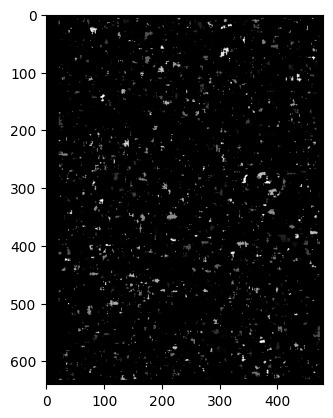

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming that two frames of images are obtained from two adjacent cameras on the left and right
left_image_rgb = np.random.rand(640, 480, 3) * 255
right_image_rgb = np.random.rand(640, 480, 3) * 255

left_image_gray = cv2.cvtColor(left_image_rgb.astype('uint8'), cv2.COLOR_RGB2GRAY)
right_image_gray = cv2.cvtColor(right_image_rgb.astype('uint8'), cv2.COLOR_RGB2GRAY)

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)

disparity = stereo.compute(left_image_gray, right_image_gray)

plt.imshow(disparity, 'gray')
plt.show()


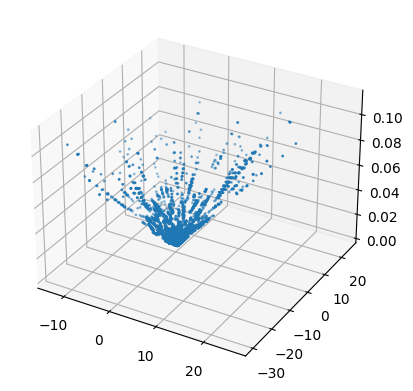

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Parameters of camera
focal_length = 1
baseline = 1

# Depth Map
depth = focal_length * baseline / (disparity + 0.0001)

# Create point cloud
h, w = depth.shape
X, Y = np.meshgrid(np.arange(w), np.arange(h))
Z = depth
X = (X - w // 2) * Z / focal_length
Y = (Y - h // 2) * Z / focal_length

points_3D = np.dstack((X, Y, Z))

# Filter out invalid points
valid_mask = (depth > 0) & (depth < 1000)
valid_points = points_3D[valid_mask]

valid_points = valid_points.reshape(-1, 3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(valid_points[:, 0], valid_points[:, 1], valid_points[:, 2], s=1)
plt.show()


In [4]:
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu121
!pip install "git+https://github.com/facebookresearch/pytorch3d.git"

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-a2ckhix2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-a2ckhix2
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit f34104cf6ebefacd7b7e07955ee7aaa823e616ac
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.6-cp310-cp310-linux_x86_64.whl size=51542927 sha256=62845aec3d751e60e241a63883917a36f69e25719bdd8dca986196d4fea0b0f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-ofd46aqn/wheels/dd/74/cc/b9266c863f19026f796e59a04e1cd9eb3754474a52ce1b66ce


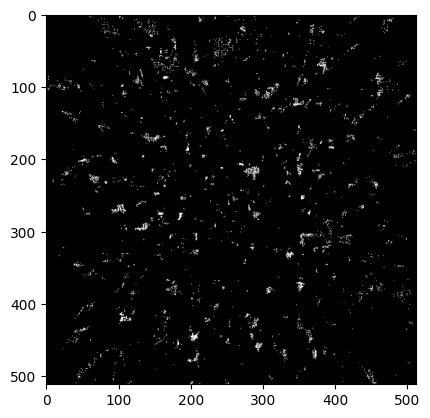

In [5]:
import torch
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
)
from pytorch3d.structures import Pointclouds
import matplotlib.pyplot as plt


points = torch.tensor(valid_points, dtype=torch.float32)

# Create a point cloud structure
colors = torch.full((points.shape[0], 3), 1.0)  # white color

# Create the Pointclouds object with points and their associated colors
cloud = Pointclouds(points=[points], features=[colors])


R, T = look_at_view_transform(2.7, 0, 180)  # camera distance, elevation, azimuth
cameras = FoVPerspectiveCameras(device="cpu", R=R, T=T)

# Rasterization settings for rendering the point cloud, can adjust the size of the points, etc.
raster_settings = PointsRasterizationSettings(
    image_size=512,
    radius = 0.003,
    points_per_pixel = 10
)

# Point renderer for rendering the point cloud
renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    compositor=AlphaCompositor()
)

images = renderer(cloud)
image_np = images[0, ..., :3].cpu().numpy()  # discard the alpha channel
plt.imshow(image_np)
plt.show()
